In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [5]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [7]:
#drop null values from description and points columns
df = df.dropna(subset=['description', 'points'])

In [8]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


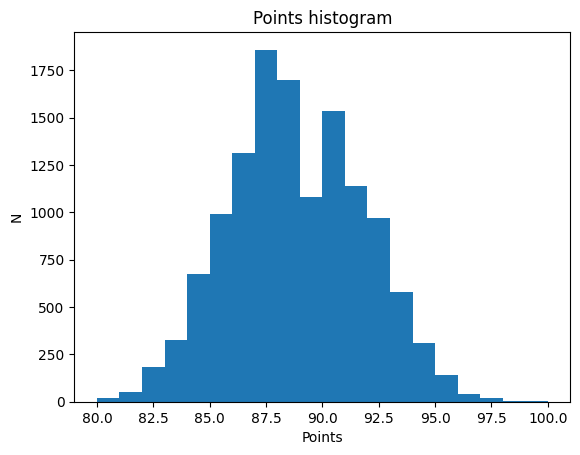

In [9]:
#histogram to show the distribution of values
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [10]:
#classify data as low tier and high tier (high => 90)
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [11]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [12]:
df.tail()

,description,label
12944,"The Côte du Py, one of the best cru vineyard s...",1
12945,Be grateful that Stéphane Aviron is an old-vin...,1
12946,As the Stolpman family's top-of-the-line bottl...,1
12947,Hailing from a precipitously perched vineyard ...,1
12948,"The tanginess of grapefruit peel, paired with ...",1


In [13]:
#splitting data into training, validation and testing data
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [14]:
len(train), len(val), len(test)

(10359, 1295, 1295)

In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [16]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding and Model development

In [17]:
#embeddings are numerical representations of real-world objects
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [18]:
#transforming all description strings into integers
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.3866796 ,  0.04863341,  0.11630529, ...,  0.01840804,
        -0.5301272 , -0.10885508],
       [ 0.44402847, -0.03095147,  0.08366879, ...,  0.05591015,
        -0.1137763 , -0.18855935],
       [ 0.5633927 , -0.26381537, -0.03271256, ...,  0.08379999,
        -0.02493   ,  0.13958028],
       ...,
       [ 0.4078642 ,  0.07952223,  0.10762661, ..., -0.08936324,
        -0.2551039 ,  0.03922943],
       [ 0.35399354, -0.09022268,  0.09748805, ..., -0.16036652,
        -0.24721561, -0.10530788],
       [ 0.5848609 , -0.18826185, -0.09681262, ...,  0.05081903,
        -0.09986147,  0.1537201 ]], dtype=float32)>

In [19]:
model = tf.keras.Sequential()
model.add(hub_layer)#1st layer just transforming strings into numericals
model.add(tf.keras.layers.Dense(16, activation='relu'))#2nd layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))#3rd layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))#final output layer

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
model.evaluate(train_data)

11/11 [==============================] - 1s 12ms/step - loss: 0.7016 - accuracy: 0.4324


[0.7016457319259644, 0.4323776364326477]

In [22]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 12ms/step - loss: 0.7010 - accuracy: 0.4517


[0.701020359992981, 0.4517374634742737]

In [23]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
11/11 [==============================] - 16s 1s/step - loss: 0.6911 - accuracy: 0.5384 - val_loss: 0.6743 - val_accuracy: 0.6170
Epoch 2/5
11/11 [==============================] - 15s 1s/step - loss: 0.6735 - accuracy: 0.6095 - val_loss: 0.6664 - val_accuracy: 0.6201
Epoch 3/5
11/11 [==============================] - 15s 1s/step - loss: 0.6639 - accuracy: 0.6281 - val_loss: 0.6602 - val_accuracy: 0.6201
Epoch 4/5
11/11 [==============================] - 15s 1s/step - loss: 0.6532 - accuracy: 0.6339 - val_loss: 0.6527 - val_accuracy: 0.6201
Epoch 5/5
11/11 [==============================] - 15s 1s/step - loss: 0.6413 - accuracy: 0.6388 - val_loss: 0.6432 - val_accuracy: 0.6201


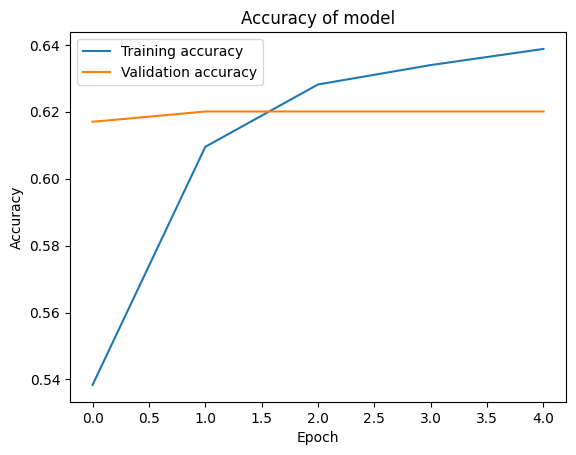

In [24]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

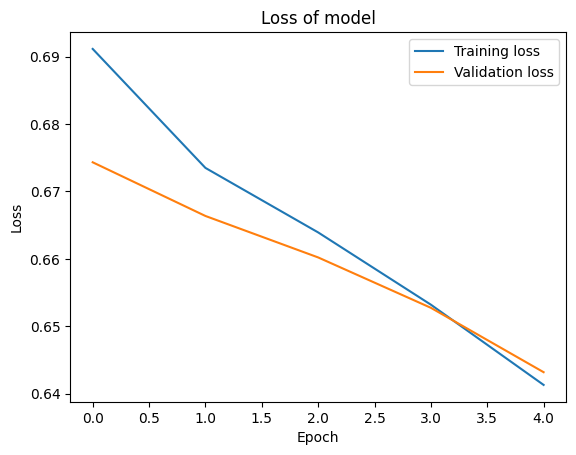

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [26]:
#evaluate on test data
model.evaluate(test_data)

2/2 [==============================] - 1s 303ms/step - loss: 0.6327 - accuracy: 0.6355


[0.6326935887336731, 0.6355212330818176]

# LSTM

In [27]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [28]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'in', 'flavors', 'it', 'to', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
model.evaluate(train_data)
model.evaluate(valid_data)

2/2 [==============================] - 0s 65ms/step - loss: 0.6933 - accuracy: 0.4903


[0.6933020353317261, 0.4903475046157837]

In [32]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
11/11 [==============================] - 9s 335ms/step - loss: 0.6852 - accuracy: 0.6159 - val_loss: 0.6721 - val_accuracy: 0.6201
Epoch 2/5
11/11 [==============================] - 5s 458ms/step - loss: 0.6577 - accuracy: 0.6346 - val_loss: 0.6544 - val_accuracy: 0.6201
Epoch 3/5
11/11 [==============================] - 4s 343ms/step - loss: 0.6386 - accuracy: 0.6346 - val_loss: 0.6314 - val_accuracy: 0.6201
Epoch 4/5
11/11 [==============================] - 4s 332ms/step - loss: 0.6047 - accuracy: 0.6365 - val_loss: 0.5875 - val_accuracy: 0.6378
Epoch 5/5
11/11 [==============================] - 5s 448ms/step - loss: 0.5361 - accuracy: 0.7117 - val_loss: 0.5296 - val_accuracy: 0.7452


In [33]:
model.evaluate(test_data)

2/2 [==============================] - 0s 38ms/step - loss: 0.5166 - accuracy: 0.7622


[0.5165755748748779, 0.7621621489524841]